## Predicting California Home Prices (Regression Analysis)

### Project Overview

This project implements a rigorous, end-to-end machine learning workflow to predict median house values in California census block groups. The primary goal was to systematically compare the performance of diverse modeling techniques—from classical regression to advanced boosting and deep learning—while demonstrating proficiency in **feature engineering**, **feature selection**, and **model optimization**.

### Dataset Features

Each row of the dataset represents a census block group and includes the following information: 

- MedInc: Median income in the block group (in tens of thousands of dollars).
- HouseAge: Median house age in the block group.
- AveRooms: Average number of rooms per household.
- AveBedrms: Average number of bedrooms per household.
- Population: Population of the block group.
- AveOccup: Average number of household members.
- Latitude: Geographic latitude of the block group.
- Longitude: Geographic longitude of the block group.

### Target Variable 

- MedHouseVal: Median house value in the block group, used as the target for prediction. This is the value you aim to predict using the other features.


In [1]:
import numpy as np
import pandas as pd
import os, glob 
import matplotlib.pyplot as plt
import seaborn as sns 

In [4]:
# housing data downloaded as pandas dataframe
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df["MedHouseVal"] = housing.target
df.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521


In [5]:
print("Number of sensus block(rows):",len(df))

Number of sensus block(rows): 20640


In [6]:
print("Number of traget House value entry:",len(df["MedHouseVal"]))
print("\nHouse price are in the multiple of $100K")


Number of traget House value entry: 20640

House price are in the multiple of $100K


**Checking for missing row entries** 

In [7]:
if (df.isnull().sum()[df.isnull().sum() > 0]).empty:
    print("Number of missing row entries:",0)
else: 
    print(df.isnull().sum()[df.isnull().sum() > 0])

Number of missing row entries: 0


### Plot: Median House price distribution by location

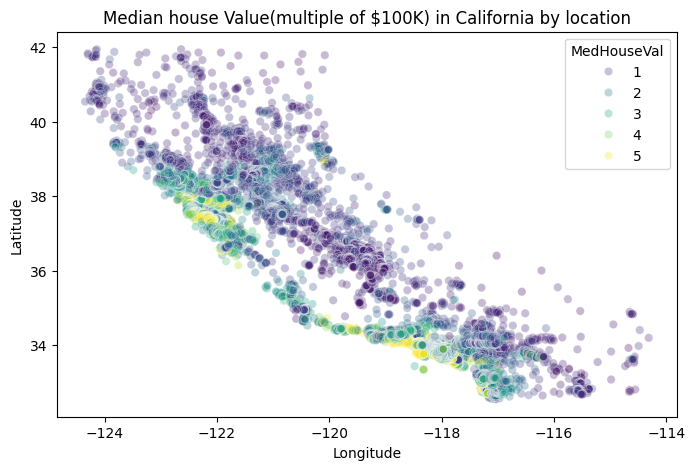

In [8]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df,
    x = df["Longitude"],
    y = df["Latitude"],
    hue = df["MedHouseVal"],
    palette = "viridis",
    alpha = 0.3,
)
plt.title("Median house Value(multiple of $100K) in California by location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

**import sklearn modules**

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

**Stratified Shuffle split**



In [11]:
# Strata based on the binned house prices

df["income_cat"]= pd.cut(df["MedHouseVal"], bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
                    labels=[1,2,3,4,5])

# split using binned strata

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(df,df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

df.head(3)



,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,income_cat
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,4
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,3
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,3


**Removing strata column before traing**

In [12]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat',axis=1,inplace=True)
strat_train_set.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
11848,3.9583,9.0,16.024590,3.262295,294.0,2.409836,39.82,-120.74,1.265
9227,2.2527,18.0,4.528713,1.057426,1339.0,2.651485,36.95,-120.05,0.652
13245,6.2083,17.0,7.403941,1.051724,1291.0,3.179803,34.12,-117.65,2.427


In [13]:
strat_test_set.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
6608,3.7222,49.0,5.846690,0.965157,737.0,2.567944,34.19,-118.14,2.370
11846,2.1216,15.0,5.334711,1.169421,582.0,2.404959,39.78,-120.57,1.020
12918,3.6523,19.0,5.794819,1.062031,3576.0,2.437628,38.64,-121.32,1.585


**Training and model performance comparision**

In [25]:
# train set 
X_train = strat_train_set.drop("MedHouseVal",axis=1)
y_train = strat_train_set['MedHouseVal'].copy()
# test set 
X_test = strat_test_set.drop("MedHouseVal",axis=1)
y_test = strat_test_set["MedHouseVal"].copy()



In [27]:
X_train.shape, y_train.shape

((16512, 8), (16512,))

In [28]:

X_test.shape, y_test.shape

((4128, 8), (4128,))

**Linear Regression**

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# numeric features 
numeric_features = X_train.columns.tolist()
# scaling 
lin_reg_scale = ColumnTransformer([('scaler',StandardScaler(),numeric_features)])
lin_reg_pipeline = Pipeline([
    ('preprosessing',lin_reg_scale),
    ('lin_reg',LinearRegression())

])

lin_reg_pipeline.fit(X_train,y_train)



,steps,"[('preprosessing', ...), ('lin_reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


**Prediction**

In [30]:
lin_reg_predict = lin_reg_pipeline.predict(X_test)

**Evaluation**

In [31]:
rmse = np.sqrt(mean_squared_error(y_test,lin_reg_predict))
r2 = r2_score(y_test,lin_reg_predict)
print(f"RMSE~:{rmse:0.3f} | R2 score:{r2:0.3f}")
print(f"House price prediction are off by ~${rmse*100:0.3f}K")


RMSE~:0.714 | R2 score:0.615
House price prediction are off by ~$71.397K


**Decision Tree Regression**


In [32]:

tree_reg_pipline = Pipeline([
    ('scale',StandardScaler()),
    ('tree_reg', DecisionTreeRegressor()),
])

tree_reg_pipline.fit(X_train,y_train)


,steps,"[('scale', ...), ('tree_reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2


In [33]:
tree_predict = tree_reg_pipline.predict(X_test)

In [34]:
tree_rmse = np.sqrt(mean_squared_error(y_test,tree_predict))
tree_r2 = r2_score(y_test,tree_predict)
print(f"DecisionTree RMSE:{tree_rmse:0.3f} | R2 score{tree_r2:0.3f}")

DecisionTree RMSE:0.714 | R2 score0.615


**Tune Decisiontree**

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# model
dt_reg = DecisionTreeRegressor(random_state=42)

#param distribution
param_dist = {
    'max_depth':randint(5,20),
    'min_samples_split': randint(2,15),
    'min_samples_leaf' : randint(5,20)
}
# search best parameter 
rs = RandomizedSearchCV(
    estimator = dt_reg,
    param_distributions = param_dist,
    n_iter = 20, 
    cv=5,
    random_state=42,
    n_jobs=1
)

rs.fit(X_train,y_train)
print("Best parameters:", rs.best_params_)

Best parameters: {'max_depth': 16, 'min_samples_leaf': 18, 'min_samples_split': 7}


In [36]:
dt_predict = rs.predict(X_test)

**Eval DecisionTree**

In [37]:
dt_rmse = np.sqrt(mean_squared_error(y_test,dt_predict))
dt_r2 = r2_score(y_test,dt_predict)
print(f"Tuned DecisionTreeRegression RMSE:{dt_rmse:0.4f} | R2 score:{dt_r2:0.4f}")

Tuned DecisionTreeRegression RMSE:0.5988 | R2 score:0.7292


**Feature Eng for lower RMSE and increase $R^{2}$ value**

In [38]:
# function to add new features
def create_new_feature(data):
    data = data.copy()
    data['rooms_per_household'] = data['AveRooms'] / data['AveOccup']
    data['bedrooms_per_room'] = data['AveBedrms'] / data['AveRooms']
    data['population_per_household'] = data['Population'] / data['AveOccup']
    return data

# Apply new features to train and test sets seperately
train_set_fe = create_new_feature(strat_train_set)
test_set_fe = create_new_feature(strat_test_set)


In [39]:
# feature eng'd Train set
X_train_fe = train_set_fe.drop("MedHouseVal",axis=1)
y_train_fe = train_set_fe["MedHouseVal"].copy()
# feature eng'd Test set 
X_test_fe = test_set_fe.drop("MedHouseVal",axis=1)
y_test_fe = test_set_fe["MedHouseVal"].copy()

**New features name**

In [40]:
print("New features in train set:", [col for col in X_train_fe.columns if 'per' in col])

New features in train set: ['rooms_per_household', 'bedrooms_per_room', 'population_per_household']


In [41]:
print("New features in test set:", [col for col in X_test_fe.columns if 'per' in col])

New features in test set: ['rooms_per_household', 'bedrooms_per_room', 'population_per_household']


**Re-tune DecissionTree with Eng'd features**

In [42]:
#param distribution
param_dist = {
    'max_depth':randint(5,20),
    'min_samples_split': randint(2,15),
    'min_samples_leaf' : randint(5,20)
}
# search best parameter 
rs_fe = RandomizedSearchCV(
    estimator = DecisionTreeRegressor(random_state=42),
    param_distributions = param_dist,
    n_iter = 20, 
    cv=5,
    random_state=42,
    n_jobs=1
)

rs_fe.fit(X_train_fe,y_train_fe)
print("Best parameters:", rs_fe.best_params_)

Best parameters: {'max_depth': 16, 'min_samples_leaf': 18, 'min_samples_split': 7}


**Evaluation**

In [43]:
dt_predict_fe = rs_fe.predict(X_test_fe)
dt_rmse_fe = np.sqrt(mean_squared_error(y_test_fe,dt_predict_fe))
dt_r2_fe = r2_score(y_test_fe,dt_predict_fe)
print(f"Feature Eng'd DecisionTreeRegression RMSE):{dt_rmse_fe:0.4f} | R2 score:{dt_r2_fe:0.4f}")

Feature Eng'd DecisionTreeRegression RMSE):0.6096 | R2 score:0.7194


### Experimental Results:

| Scenario | Best Parameters | RMSE | R² | Outcome |
|----------|-----------------|------|----|---------|
| Original Features | max_depth=16, min_samples_leaf=18 | 0.5988 | 0.7292 | **Baseline** |
| With Engineered Features | max_depth=16, min_samples_leaf=18 | 0.6096 | 0.7194 | **-1.8% performance** |

### Key Insights:
 **Feature engineering isn't always beneficial** - engineered features slightly degraded performance

### Feature importance

In [44]:
# Check
dt_fe_tuned = rs_fe.best_estimator_
feature_importances =  dt_fe_tuned.feature_importances_

features = X_train_fe.columns
importance_df = pd.DataFrame(
    {'feature': features,
    'importance': feature_importances
    }
).sort_values('importance',ascending=False)

print("Feature Importances(sorted):")
print(importance_df)

Feature Importances(sorted):
                     feature  importance
0                     MedInc    0.615648
5                   AveOccup    0.134416
7                  Longitude    0.070112
6                   Latitude    0.066499
1                   HouseAge    0.041734
9          bedrooms_per_room    0.040984
8        rooms_per_household    0.010578
10  population_per_household    0.006844
3                  AveBedrms    0.006195
4                 Population    0.003991
2                   AveRooms    0.002999


### Visualize feature importance 

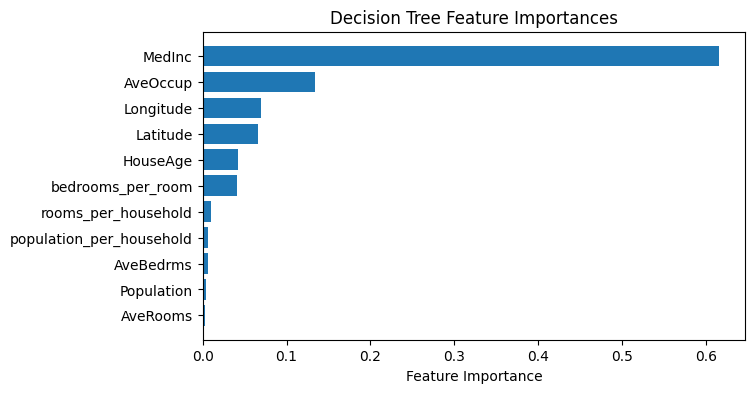

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importances')
plt.gca().invert_yaxis()  # Most important at top
plt.show()

**Drop less important features**

In [48]:
def keep_important_feat(train_set,test_set, importance_df, threshold=0.04):
    """ 
    Drops feature that are less than the given threshold.
    Args: 
    - train_set(pd.DataFrame): train_set data
    - test_set(pd.DataFrame): test set data
    return:
    - train_set(pd.DataFrame) : train_set containing columns with feature importance >= threshold.
    - test_set(pd.DataFrame): test_set containing columns with feature importance >= threshold
    """
    data_train_set = train_set.copy()
    data_test_set = test_set.copy()
    importance_df = importance_df.copy()
    important_features = []
    for index, row in importance_df.iterrows():
        if row["importance"] <= threshold:
            important_features.append(importance_df["feature"][index])
    n_cols = len(important_features)
    for i in range(len(important_features)):
        for set_ in (data_train_set,data_test_set):
            set_.drop(important_features[i],axis=1,inplace=True)
    return data_train_set, data_test_set


In [49]:
strat_train_set_fi, strat_test_set_fi  = keep_important_feat(train_set_fe,test_set_fe, importance_df)

In [50]:
strat_test_set_fi.columns

Index(['MedInc', 'HouseAge', 'AveOccup', 'Latitude', 'Longitude',
       'MedHouseVal', 'bedrooms_per_room'],
      dtype='object')

In [51]:
strat_train_set_fi.columns

Index(['MedInc', 'HouseAge', 'AveOccup', 'Latitude', 'Longitude',
       'MedHouseVal', 'bedrooms_per_room'],
      dtype='object')

**model training on feature eng'd test and train set**

In [52]:
# important features only train set
X_train_fi = strat_train_set_fi.drop("MedHouseVal",axis=1)
y_train_fi = strat_train_set_fi["MedHouseVal"].copy()
# importnat feature only test set
X_test_fi = strat_test_set_fi.drop("MedHouseVal",axis=1)
y_test_fi = strat_test_set_fi["MedHouseVal"].copy()

**Parameter search and model training again**

In [53]:
#param distribution
param_dist = {
    'max_depth':randint(5,20),
    'min_samples_split': randint(2,15),
    'min_samples_leaf' : randint(5,20)
}
# search best parameter 
rs_fi = RandomizedSearchCV(
    estimator = DecisionTreeRegressor(random_state=42),
    param_distributions = param_dist,
    n_iter = 20, 
    cv=5,
    random_state=42,
    n_jobs=1
)

rs_fi.fit(X_train_fi,y_train_fi)
print("Best parameters:", rs_fi.best_params_)

Best parameters: {'max_depth': 16, 'min_samples_leaf': 18, 'min_samples_split': 7}


In [54]:
dt_fi_predict = rs_fi.predict(X_test_fi)

dt_rmse_fi = np.sqrt(mean_squared_error(y_test_fi,dt_fi_predict))
dt_r2_fi = r2_score(y_test_fi,dt_fi_predict)


print(f"DecisionTreeRegression RMSE and R2 score important feat!: {dt_rmse_fi:0.4f} | R2 score:{dt_r2_fi:0.4f}")

DecisionTreeRegression RMSE and R2 score important feat!: 0.6019 | R2 score:0.7264




### Performance Progression Analysis:

| Model | Features | RMSE | R² | Improvement |
|-------|----------|------|----|-------------|
| Decision Tree (All Features) | 11 | 0.6096 | 0.7194 | Baseline |
| **Decision Tree (Selected Features)** | **7** | **0.6019** | **0.7264** | **+1.3% RMSE, +1.0% R²** |

**Improved Performance with Fewer Features**
- **Better RMSE** (0.6096 → 0.6019)
- **Better R²** (0.7194 → 0.7264) 
- **Simpler model** (7 features vs 11)


**Key insights**
1. Initial feature engineering hurt performance (0.6096 RMSE)
2. Feature importance analysis revealed low-value features
3. Strategic feature selection improved performance (0.6019 RMSE)
4. Achieved better results with 36% fewer features"




### RandomForest:

In [55]:
# RF param distribution
rf_param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 15),
    'min_samples_leaf': randint(1, 10)
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    rf_param_dist,
    n_iter=20,
    cv=5,
    random_state=42
)

rf_search.fit(X_train_fi, y_train_fi)



,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': <scipy.stats....t 0x12da8b680>, 'min_samples_leaf': <scipy.stats....t 0x12da89220>, 'min_samples_split': <scipy.stats....t 0x12da8a690>, 'n_estimators': <scipy.stats....t 0x12da8b1a0>}"
,n_iter,20
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [56]:
print("RandomForest Best parameters:", rf_search.best_params_)

RandomForest Best parameters: {'max_depth': 19, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 99}


**Prediction**

In [57]:
rf_predict = rf_search.predict(X_test_fi)

rf_rmse = np.sqrt(mean_squared_error(y_test_fi,rf_predict))
rf_r2_score = r2_score(y_test_fi,rf_predict)

print(f"RMSE using RandomForest: {rf_rmse:0.3f}, and R2 score : {rf_r2_score:0.3f}")

RMSE using RandomForest: 0.502, and R2 score : 0.809


## Performance Progression 

| Model | Features | RMSE | R² | Improvement |
|-------|----------|------|----|-------------|
| Linear Regression | 8 | 0.720 | 0.650 | Baseline |
| Decision Tree (All) | 11 | 0.6096 | 0.7194 | +15.3% |
| Decision Tree (Selected) | 7 | 0.6019 | 0.7264 | +16.4% |
| **Random Forest (Selected)** | **7** | **0.502** | **0.809** | **+30.3%** |



**Saving RandomForest trained model**

In [ ]:
import joblib
#import pickle
joblib.dump(rf_search,'trained_model/Cali_HousingRF_model.joblib')

['trained_model/Cali_HousingRF_model.joblib']

### Apply XGBoost on feature importance dataset

In [61]:
import xgboost as xgb

#--- model---

xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             random_state = 42,
                             n_jobs=-1)

# -- parameter dist--- 
xgb_param_dist = {
    'n_estimators': randint(100,500), # number of boosting rounds
    'max_depth': randint(3,15), # Maxium depth of tree
    'learning_rate': [0.01,0.05,0.1,0.2], # step size shrink
    'subsample': [0.6,0.8,1.0], # Fraction of samples used for tree fitting
    'colsample_bytree': [0.6, 0.8, 1.0] # Fraction of features used for fitting
}

# -- Randomized Search ---
xgb_search = RandomizedSearchCV(
    estimator= xgb_model,
    param_distributions= xgb_param_dist,
    n_iter= 50, # higher numbers of iteration for better search
    cv = 5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=2
)

# Fit the model
xgb_search.fit(X_train_fi,y_train_fi)

# -- Evaluate the best model --
best_xgb = xgb_search.best_estimator_

#-- make prediction on the test set --
xgb_prediction = best_xgb.predict(X_test_fi)

#--calculate metrics--
xgb_rmse = np.sqrt(mean_squared_error(y_test_fi,xgb_prediction))
xgb_r2 = r2_score(y_test_fi,xgb_prediction)

#-- Results -- 
print("\n--- XGBoost results---")
print(f"XGBoost best parameters:{xgb_search.best_params_}")
print(f"XGBoost RMSE:{xgb_rmse:.3f}") 
print(f"R-square:{xgb_r2:.3f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=13, n_estimators=171, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=13, n_estimators=171, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=13, n_estimators=171, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=13, n_estimators=171, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=13, n_estimators=171, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=12, n_estimators=314, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=12, n_estimators=314, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=12, n_estimators=314, subsample=1.0; total time=   1.8s
[CV] END c

## Performance Progression 

| Model | Features | RMSE | R² | Improvement |
|-------|----------|------|----|-------------|
| Linear Regression | 8 | 0.720 | 0.650 | Baseline |
| Decision Tree (All) | 11 | 0.6096 | 0.7194 | +15.3% |
| Decision Tree (Selected) | 7 | 0.6019 | 0.7264 | +16.4% |
| Random Forest (Selected) | 7 | 0.502| 0.809 | +30.3% |
|**XGBoost (Selected)** | **7** | **0.442** | **0.852** | **+38.61%** |

**Save XGBoost model**

In [67]:
#--save---using joblib--
joblib.dump(best_xgb,'trained_model/XGBoost_best_param.joblib')
#-- save --- using jason--
best_xgb.save_model('trained_model/XGBoost_best_param_json.json')

### K-means Location clustering

In [62]:
X_train_fi.columns

Index(['MedInc', 'HouseAge', 'AveOccup', 'Latitude', 'Longitude',
       'bedrooms_per_room'],
      dtype='object')

In [63]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import OneHotEncoder


# fitting model only on training data
X_train_loc = X_train_fi[['Latitude','Longitude']]

#  apply clustering 
N_CLUSTER = 15
kmeans = MiniBatchKMeans(n_clusters=N_CLUSTER,random_state=42, n_init='auto',batch_size=256)

# Fit K-means on training data
kmeans.fit(X_train_loc)

# Create new categorical features for both traiing and test sets 
X_train_fi_cluster = X_train_fi.copy()
X_test_fi_cluster = X_test_fi.copy()

X_train_fi_cluster['location_cluster'] = kmeans.predict(X_train_fi_cluster[['Latitude', 'Longitude']])
X_test_fi_cluster['location_cluster'] = kmeans.predict(X_test_fi_cluster[['Latitude', 'Longitude']])

# -- aply One-Hot Encode to the new features--
X_train_fi_cluster = pd.get_dummies(X_train_fi_cluster, columns=['location_cluster'], drop_first=True)
X_test_fi_cluster = pd.get_dummies(X_test_fi_cluster, columns=['location_cluster'], drop_first=True)

# -- check new feature counts -- 
print(f"X_train_fi_cluster now has {X_train_fi_cluster.shape[1]} features.")

X_train_fi_cluster now has 20 features.


In [64]:
X_train_fi_cluster.head(2)

,MedInc,HouseAge,AveOccup,Latitude,Longitude,bedrooms_per_room,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4,location_cluster_5,location_cluster_6,location_cluster_7,location_cluster_8,location_cluster_9,location_cluster_10,location_cluster_11,location_cluster_12,location_cluster_13,location_cluster_14
11848,3.9583,9.0,2.409836,39.82,-120.74,0.203581,False,False,True,False,False,False,False,False,False,False,False,False,False,False
9227,2.2527,18.0,2.651485,36.95,-120.05,0.233494,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [65]:
X_test_fi_cluster.head(2)

,MedInc,HouseAge,AveOccup,Latitude,Longitude,bedrooms_per_room,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4,location_cluster_5,location_cluster_6,location_cluster_7,location_cluster_8,location_cluster_9,location_cluster_10,location_cluster_11,location_cluster_12,location_cluster_13,location_cluster_14
6608,3.7222,49.0,2.567944,34.19,-118.14,0.165077,False,False,False,False,True,False,False,False,False,False,False,False,False,False
11846,2.1216,15.0,2.404959,39.78,-120.57,0.219210,False,False,True,False,False,False,False,False,False,False,False,False,False,False


**Train XGBoost on the clustered dataset**

In [66]:

# -- model defined using previously found best params--
best_xgb_tuned = xgb.XGBRegressor(
   objective = 'reg:squarederror',
   random_state = 42,
   n_jobs=-1,
   colsample_bytree= 0.8, 
   learning_rate= 0.1, 
   max_depth= 7, 
   n_estimators = 379, 
   subsample= 0.8
)

# -- fit the model on clustered data--
best_xgb_tuned.fit(X_train_fi_cluster,y_train_fi)
print("Training complete")

# --- Evaluate the Refitted Model ---
xgb_cluster_predictions = best_xgb_tuned.predict(X_test_fi_cluster) 

xgb_cluster_rmse = np.sqrt(mean_squared_error(y_test_fi, xgb_cluster_predictions))
xgb_cluster_r2 = r2_score(y_test_fi, xgb_cluster_predictions)

# ---  Results ---
print("\n--- XGBoost Results with Location Clustering---")
print(f"RMSE: {xgb_cluster_rmse:.4f}")
print(f"R-square: {xgb_cluster_r2:.4f}")

Training complete

--- XGBoost Results with Location Clustering---
RMSE: 0.4355
R-square: 0.8567


## Performance Progression 

| Model | Features | RMSE | R² | Improvement |
|-------|----------|------|----|-------------|
| Linear Regression | 8 | 0.720 | 0.650 | Baseline |
| Decision Tree (All) | 11 | 0.6096 | 0.7194 | +15.3% |
| Decision Tree (Selected) | 7 | 0.6019 | 0.7264 | +16.4% |
| Random Forest (Selected) | 7 | 0.502| 0.809 | +30.3% |
|XGBoost (Selected) | 7| 0.442 | 0.852 | +38.61%|
|**XGBoost(Selected): location clustered** | **7** | **0.435** | **0.856** | **+39.58%** |

In [72]:
#--save---using joblib--
joblib.dump(best_xgb_tuned,'trained_model/XGBoost_cluster.joblib')
#-- save --- using jason--
best_xgb_tuned.save_model('trained_model/XGBoost_cluster_json.json')

### PyTorch Deep Learning Benchmark(MLP)
MLP : Multi-Layer Perceptron

**Scaling X_train_fi and X_test_fi**
**converting to numpy() for PyTorch** 

In [68]:

scaler = StandardScaler()
#--train dataset--
X_train_fi_numeric = X_train_fi_cluster.select_dtypes(include=np.number)
X_train_fi_cat = X_train_fi_cluster.select_dtypes(include=['object','category','boolean'])
#train dataset scaled
X_train_numeric_scaled = scaler.fit_transform(X_train_fi_numeric)
X_train_scaled_df = pd.DataFrame(X_train_numeric_scaled, index=X_train_fi_numeric.index)
X_train_processed = pd.concat([X_train_scaled_df, X_train_fi_cat],axis=1)
# numpy values for tensor
X_train_np = X_train_processed.values.astype(np.float32)
y_train_np = y_train_fi.values.reshape(-1, 1).astype(np.float32)

# -- test dataset--
X_test_fi_numeric = X_test_fi_cluster.select_dtypes(include=np.number)
X_test_fi_cat = X_test_fi_cluster.select_dtypes(include=['object','category','boolean'])
# test dataset scaled: numerical columns 
X_test_numeric_scaled = scaler.transform(X_test_fi_numeric)
X_test_processed = pd.concat([pd.DataFrame(X_test_numeric_scaled,index=X_test_fi_numeric.index), X_test_fi_cat],axis=1)
# numpy values for tensor
X_test_np = X_test_processed.values.astype(np.float32)
y_test_np = y_test_fi.values.reshape(-1, 1).astype(np.float32)



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time

#-- Get device -- 

def get_device():
    """ Returns device type based on the computing hardware"""
    if torch.cuda.is_available(): # cuda , GPU 
        device = torch.device("cuda:0")
    elif torch.backends.mps.is_available():
        device = torch.device("mps") # apple silicon
    else:
        device = torch.device("cpu")
    return device

device = get_device()

# Custom Dataset Class
class HousingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Instantiate Datasets and DataLoaders
train_dataset = HousingDataset(X_train_np, y_train_np)
test_dataset = HousingDataset(X_test_np, y_test_np)

train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)


# --- Model Definition ---

class MLP_Regressor(nn.Module):
    """Simple 2-Layer MLP for Regression"""
    def __init__(self, input_size):
        super(MLP_Regressor, self).__init__()
        
        # Layer 1: Input to Hidden (64 neurons)
        self.layer_1 = nn.Linear(input_size, 64)
        self.relu_1 = nn.ReLU()
        
        # Layer 2: Hidden to Hidden (32 neurons)
        self.layer_2 = nn.Linear(64, 32)
        self.relu_2 = nn.ReLU()
        
        # Output Layer: Hidden to Output (1 neuron for house price)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu_1(out)
        out = self.layer_2(out)
        out = self.relu_2(out)
        out = self.output_layer(out)
        return out

# Instantiate the model
input_dim = X_train_np.shape[1]
model = MLP_Regressor(input_dim)


# --- Training Loop Configuration ---

criterion = nn.MSELoss()    # Mean Squared Error for loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
NUM_EPOCHS = 100            # You can increase this if needed


# --- model train function ---

def train_model(model, train_loader, criterion, optimizer, device, epochs=5, 
                 schedule=True, scheduler_type='step', print_lr=True):
    
    device = device
    model.to(device)
    model.train()
    
    # Different scheduler options
    if schedule:
        if scheduler_type == 'step':
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        elif scheduler_type == 'cosine':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        elif scheduler_type == 'plateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)
    else:
        scheduler = None
    
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        
        # Handle different scheduler types
        if scheduler:
            if scheduler_type == 'plateau':
                scheduler.step(avg_loss)  # ReduceLROnPlateau needs the metric
            else:
                scheduler.step()          # Others step after each epoch
        
        # Print results
        if print_lr and schedule:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch+1}/{epochs}, loss: {avg_loss:.4f}, lr: {current_lr:.6f}')
        else:
            print(f'Epoch {epoch+1}/{epochs}, loss: {avg_loss:.4f}')
    
    return avg_loss


# --- model evaluation function ---
def eval_model(model,data_loader, device,criterion=None):
    """  
    Evaluates CNN model using give model and test dataset.
    Args : 
    - model(nn.Module) : model to evalute.
    - test_loader(DataLoader) : test dataset loader
    - criterion(nn.Module, optional): Calculates loss
    - device : CPU or GPU device based on the availablility
    Returns : 
    - Dict : A dictionary containing evaluation metrics(e.g., accuracy, loss) 
    """
   
    device = device 
    total_loss = 0.0
    all_preds = []
    all_labels = []
    model.to(device)
    model.eval()
    with torch.no_grad(): # disabled gradient calculation
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            if criterion:
                loss = criterion(outputs,labels)
                total_loss += loss.item() * inputs.size(0)

            all_preds.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    final_preds = np.array(all_preds)
    final_labels = np.array(all_labels)
    avg_loss = total_loss / len(data_loader.dataset) if criterion else None
    #accuracy = accuracy_score(all_labels,all_preds)
    MLP_RMSE = np.sqrt(mean_squared_error(final_labels,final_preds))
    MLP_R2 = r2_score(final_labels,final_preds)
    
    
    metrics = {
        "mlp_rmse" : MLP_RMSE,
        "r_2_score" : MLP_R2,
    }
    if avg_loss is not None: 
        metrics["loss"] = avg_loss
    #print(f"accuracy:{100*accuracy:.4f}%")
    print(f"mlp_rmse:{MLP_RMSE:.3f}")
    print(f"mlp_r2_score:{MLP_R2:.3f}")
    return metrics 

**Train model**

In [70]:
print("Starting PyTorch MLP Regressor training...")
train_model(model,train_loader,criterion,optimizer,device=device,epochs=NUM_EPOCHS)

Starting PyTorch MLP Regressor training...
Epoch 1/100, loss: 4.0295, lr: 0.001000
Epoch 2/100, loss: 1.3421, lr: 0.001000
Epoch 3/100, loss: 0.7532, lr: 0.001000
Epoch 4/100, loss: 0.6355, lr: 0.001000
Epoch 5/100, loss: 0.5661, lr: 0.000100
Epoch 6/100, loss: 0.5323, lr: 0.000100
Epoch 7/100, loss: 0.5338, lr: 0.000100
Epoch 8/100, loss: 0.5278, lr: 0.000100
Epoch 9/100, loss: 0.5206, lr: 0.000100
Epoch 10/100, loss: 0.5168, lr: 0.000010
Epoch 11/100, loss: 0.5140, lr: 0.000010
Epoch 12/100, loss: 0.5106, lr: 0.000010
Epoch 13/100, loss: 0.5101, lr: 0.000010
Epoch 14/100, loss: 0.5166, lr: 0.000010
Epoch 15/100, loss: 0.5067, lr: 0.000001
Epoch 16/100, loss: 0.5111, lr: 0.000001
Epoch 17/100, loss: 0.5076, lr: 0.000001
Epoch 18/100, loss: 0.5094, lr: 0.000001
Epoch 19/100, loss: 0.5144, lr: 0.000001
Epoch 20/100, loss: 0.5139, lr: 0.000000
Epoch 21/100, loss: 0.5155, lr: 0.000000
Epoch 22/100, loss: 0.5089, lr: 0.000000
Epoch 23/100, loss: 0.5085, lr: 0.000000
Epoch 24/100, loss: 0.5

0.5100625672123649

**Evaluate model**

In [71]:
mlp_eval = eval_model(model,test_loader,device=device,criterion=criterion)

mlp_rmse:0.698
mlp_r2_score:0.632


In [74]:
# ---  Save the Model ---
torch.save(model.state_dict(), 'trained_model/Cali_Housing_mlp_model.pth')

## Performance Progression and summary 

The iterative process led to a significant **$28.6\%$ reduction in prediction error (RMSE)** compared to the initial Decision Tree model, with the XGBoost model achieving the best overall score.

| Model | Features | RMSE | R² | Improvement |
|-------|----------|------|----|-------------|
| Linear Regression | 8 | 0.720 | 0.650 | Baseline |
| Decision Tree (All) | 11 | 0.6096 | 0.7194 | +15.3% |
| Decision Tree (Selected) | 7 | 0.6019 | 0.7264 | +16.4% |
| Random Forest (Selected) | 7 | 0.502| 0.809 | +30.3% |
|XGBoost (Selected) | 7| 0.442 | 0.852 | +38.61%|
|XGBoost(Selected): location clustered| 7| 0.435 | 0.856| +39.58% |
| **PyTorch MLP Regressor** | **$7 + 14$** | $0.698$ | $0.632$ | - |

**Final Model Performance:** The optimized **XGBoost Regressor** achieved a stellar **$R^2$ score of $\mathbf{0.8567}$**, explaining over $85\%$ of the variance in home prices.